/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/10: 100%|██████████| 1804/1804 [03:27<00:00,  8.70batch/s, Avg Loss=1.33]


Epoch [1/10] - Avg Loss: 1.3348
Epoch [1/10] - Accuracy on Test Data: 0.7328


Epoch 2/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.73batch/s, Avg Loss=0.659]


Epoch [2/10] - Avg Loss: 0.6592
Epoch [2/10] - Accuracy on Test Data: 0.8002


Epoch 3/10: 100%|██████████| 1804/1804 [03:25<00:00,  8.76batch/s, Avg Loss=0.405]


Epoch [3/10] - Avg Loss: 0.4053
Epoch [3/10] - Accuracy on Test Data: 0.8718


Epoch 4/10: 100%|██████████| 1804/1804 [03:25<00:00,  8.76batch/s, Avg Loss=0.236]


Epoch [4/10] - Avg Loss: 0.2363
Epoch [4/10] - Accuracy on Test Data: 0.8869


Epoch 5/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.73batch/s, Avg Loss=0.153]


Epoch [5/10] - Avg Loss: 0.1525
Epoch [5/10] - Accuracy on Test Data: 0.9097


Epoch 6/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.73batch/s, Avg Loss=0.106]


Epoch [6/10] - Avg Loss: 0.1061
Epoch [6/10] - Accuracy on Test Data: 0.9164


Epoch 7/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.73batch/s, Avg Loss=0.0839]


Epoch [7/10] - Avg Loss: 0.0839
Epoch [7/10] - Accuracy on Test Data: 0.9157


Epoch 8/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.73batch/s, Avg Loss=0.0718]


Epoch [8/10] - Avg Loss: 0.0718
Epoch [8/10] - Accuracy on Test Data: 0.9195


Epoch 9/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.75batch/s, Avg Loss=0.0609]


Epoch [9/10] - Avg Loss: 0.0609
Epoch [9/10] - Accuracy on Test Data: 0.9317


Epoch 10/10: 100%|██████████| 1804/1804 [03:26<00:00,  8.75batch/s, Avg Loss=0.0525]


Epoch [10/10] - Avg Loss: 0.0525
Epoch [10/10] - Accuracy on Test Data: 0.9264


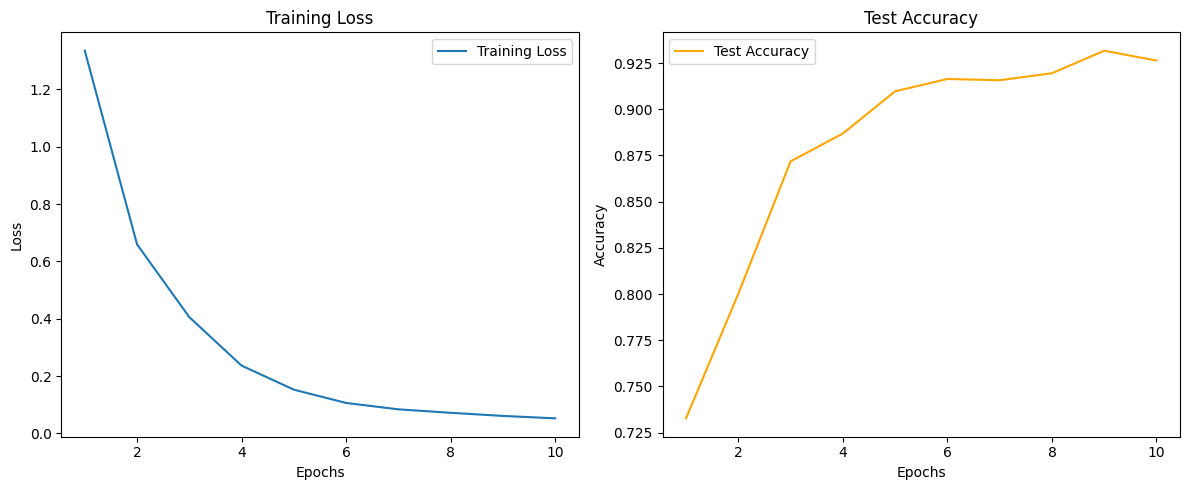

Evaluating: 100%|██████████| 451/451 [00:14<00:00, 30.83it/s]


Overall Performance Metrics:

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       628
           1       0.91      0.93      0.92       662
           2       0.93      0.94      0.94       636
           3       0.89      0.89      0.89       630
           4       0.94      0.93      0.94       646
           5       0.97      0.94      0.95       678
           6       0.93      0.92      0.92       629

    accuracy                           0.93      4509
   macro avg       0.93      0.93      0.93      4509
weighted avg       0.93      0.93      0.93      4509


Overall Accuracy: 0.9264


Per-Class Performance:

Class 0: Accuracy = 0.9315
Class 1: Accuracy = 0.9335
Class 2: Accuracy = 0.9434
Class 3: Accuracy = 0.8873
Class 4: Accuracy = 0.9350
Class 5: Accuracy = 0.9366
Class 6: Accuracy = 0.9157


In [2]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F

# Custom Model Definition with ELECTRA and CNN layers
class ElectraWithCNN(nn.Module):
    def __init__(self, base_model_name, num_labels):  # Corrected __init__ method
        super(ElectraWithCNN, self).__init__()  # Corrected __init__ method
        self.electra = AutoModelForSequenceClassification.from_pretrained(base_model_name, output_hidden_states=True)
        hidden_size = self.electra.config.hidden_size
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(32, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states[-1]  # Extract the last hidden state
        
        x = hidden_states.permute(0, 2, 1)  # Reshape to [batch_size, hidden_size, seq_length]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Global max pooling
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
        
        # Classification layer
        logits = self.fc(x)
        
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/electra-base-discriminator")

# Load dataset
df = pd.read_excel('/kaggle/input/isear-dataset/combined dataset.xlsx')

# Split dataset
Comment_train, Comment_test, Label_train, Label_test = train_test_split(df['content'], df['labels'], test_size=0.2, random_state=18)

# Tokenize the data
encodedata_train = tokenizer.batch_encode_plus(
    Comment_train.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

encodedata_test = tokenizer.batch_encode_plus(
    Comment_test.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

# Prepare data for DataLoader
input_ids_train = encodedata_train['input_ids']
attention_masks_train = encodedata_train['attention_mask']
labels_train = torch.tensor(Label_train.to_numpy(), dtype=torch.long)

input_ids_test = encodedata_test['input_ids']
attention_masks_test = encodedata_test['attention_mask']
labels_test = torch.tensor(Label_test.to_numpy(), dtype=torch.long)

tensordataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
tensordataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_loader = DataLoader(tensordataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(tensordataset_test, batch_size=10, shuffle=False)

# Define model, loss function, and optimizer
model = ElectraWithCNN(base_model_name="google/electra-base-discriminator", num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress_bar.n + 1)
        progress_bar.set_postfix({'Avg Loss': avg_loss})

    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs['logits'], 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Accuracy on Test Data: {accuracy:.4f}')

# Plotting Loss and Accuracy graphs
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed Performance Metrics Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs['logits']
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performance metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, labels=list(range(7)), zero_division=1)
accuracy = accuracy_score(all_labels, all_preds)

print("\nOverall Performance Metrics:\n")
print(class_report)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Per-class performance
print("\nPer-Class Performance:\n")
for i in range(7):  # Adjust number of classes accordingly
    class_accuracy = conf_matrix[i, i] / conf_matrix[i, :].sum() if conf_matrix[i, :].sum() > 0 else 0
    print(f"Class {i}: Accuracy = {class_accuracy:.4f}")
